## Import model

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim import lr_scheduler
from torchvision import transforms
import torchvision
from tqdm import tqdm
import pandas as pd
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Run on GPU if possible

BREED_DICT = {0: 'Abyssinian', 1: 'American bulldog', 2: 'American pit bull terrier', 3: 'Basset hound', 4: 'Beagle', 5: 'Bengal', 6: 'Birman', 7: 'Bombay', 8: 'Boxer', 9: 'British shorthair', 10: 'Chihuahua', 11: 'Egyptian mau', 12: 'English cocker spaniel', 13: 'English setter', 14: 'German shorthaired', 15: 'Great pyrenees', 16: 'Havanese', 17: 'Japanese chin', 18: 'Keeshond', 19: 'Leonberger', 20: 'Maine coon', 21: 'Miniature pinscher', 22: 'Newfoundland', 23: 'Persian', 24: 'Pomeranian', 25: 'Pug', 26: 'Ragdoll', 27: 'Russian blue', 28: 'Saint bernard', 29: 'Samoyed', 30: 'Scottish terrier', 31: 'Shiba inu', 32: 'Siamese', 33: 'Sphynx', 34: 'Staffordshire bull terrier', 35: 'Wheaten terrier', 36: 'Yorkshire terrier'}

# resnet18 = models.resnet18(pretrained=True)

## Import data set

In [2]:
class BinaryDataset(torch.utils.data.Dataset):
    """
    Converts our breed dataset to a binary species dataset, 0 is cat and 1 is dog
    """
    _cats = {0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33}

    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        image, label = self.dataset[index]
        new_label = 0 if label in self._cats else 1
        return image, new_label

    def __len__(self):
        return len(self.dataset)

def get_model(binary=True, freeze=True, freeze_BN=True):
  """
  Load the Resnet 18 model and reshapes the final layer to match the number of outputs.

  :param outputs:  Shape of output, i.e. number of classes
  :param freeze: Boolean marking if all layers except final linear layer should be frozen
  :param freeze_BN: Boolean marking if all batch norm layers should be frozen
  """
  model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
  if binary:
    outputs = 2
  else:
    outputs = 37

  if freeze:
    for param in model.parameters():
      param.requires_grad = False

  if freeze_BN:
    model.apply(freeze_bn_layers)

  num_ftrs = model.fc.in_features # Number of input features to the fully connected layer (512 for resnet18)
  model.fc = nn.Linear(in_features=num_ftrs, out_features=outputs)
  model.to(device)
  return model

def freeze_bn_layers(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
      module.eval()

In [3]:
class NetworkManager:
  """
  Class for training and evaluating models, initialized with parameters/requirements used during training
  Trainer also keeps track of data through a DataHandler instance, thus data can be accessed through Trainer
  """
  def __init__(self,
               binary=False,
               unfreeze_layers=False,
               changing_lr=False,
               augment_data=False,
               tune_batch_norm = False,
               pseudo_label=False,
               labeled_proportion=1.0):
    """
    Initialize Trainer

    :param binary: If training is done on a binary dataset (2 classes) or breed dataset (37 classes)
    :param unfreeze_layers: If, during training, layers of the model should be gradually unfrozen
    :param changing_lr: If learning rate should vary during training
    :param augment_data: If training data should be randomly augmented each batch
    :param tune_batch_norm: Whether BatchNorms should be tuned during training
    :param pseudo_label: If data should be pseudo labeled
    :param labeled_proportion: What part of training data should be labeled initially (updated further into training if pseudo labelling)
    """
    # General training settings
    self.binary = binary
    self.unfreeze_layers = unfreeze_layers
    self.changing_lr = changing_lr
    self.augment_data = augment_data
    self.tune_batch_norm = tune_batch_norm
    self.pseudo_label = pseudo_label
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if binary:
      self.label_index = {0: 'Cat', 1: 'Dog'}
    else:
      self.label_index = BREED_DICT

    if augment_data:
      self.data_transform = transforms.Compose([
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize data
          transforms.Resize(450, antialias=True), # Make larger for later cropping
          transforms.RandomRotation(30), # Rotate by ±10 degrees
          transforms.RandomCrop(380), # Crop of image randomly
          transforms.RandomHorizontalFlip(), # Randomly mirror image
          ])
    else:
      self.data_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])

    self.labeled_proportion = labeled_proportion
    if pseudo_label:
      self.data_handler = LabelingHandler(binary,
                                          n_batch=100,
                                          validation_proportion=0.2,
                                          labeled_proportion=labeled_proportion)
    else:
      self.data_handler = DataHandler(binary,
                                      n_batch=100,
                                      validation_proportion=0.2,
                                      labeled_proportion=labeled_proportion)
    self.gradual_labeling = False

  def train(self, model,
            epochs=10,
            learning_rate=0.001,
            track_loss=True,
            unfreeze_every = 3,
            gamma = 0.9):

    ### Learning rate
    layers = 7
    scaling_lr_param = 2
    if self.unfreeze_layers:
      _lr = [10**(-(layers - i) / scaling_lr_param) * learning_rate for i in range(1, 8)]
    else:
      _lr = [learning_rate for i in range(7)]
      #_lr = [((i+1)/layers)*(lr_max-lr_min) for i in range(6)]
    optimizer_params = [{'params': model.conv1.parameters(), 'lr': _lr[0]},
                        {'params': model.bn1.parameters(), 'lr': _lr[1]},
                        {'params': model.layer1.parameters(), 'lr': _lr[2]},
                        {'params': model.layer2.parameters(), 'lr': _lr[3]},
                        {'params': model.layer3.parameters(), 'lr': _lr[4]},
                        {'params': model.layer4.parameters(), 'lr': _lr[5]},
                        {'params': model.fc.parameters(), 'lr': _lr[6]}]

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(optimizer_params, lr=learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)

    if self.gradual_labeling and self.pseudo_label:
      # Initialize gradual labelling for even distribution of additional data over epochs
      self.data_handler.update_gradually(epochs)

    train_loader, val_loader, _ = self.data_handler.get_loaders()

    if track_loss:
      train_loss = [self.check_loss(train_loader, model, criterion)]
      val_loss = [self.check_loss(val_loader, model, criterion)]
    else:
      train_loss, val_loss = None, None

    if self.unfreeze_layers:
      total_layers = len(list(model.children()))

    for epoch in tqdm(range(epochs)):
      if self.gradual_labeling and self.pseudo_label:
        # Add additional labels to dataset at the start of each epoch if gradual
        # labeling has been set.
        self.data_handler.update(model, self.device)
        train_loader, _, _ = self.data_handler.get_loaders()

      if self.unfreeze_layers:
        unfreeze = epoch // unfreeze_every
        # Unlock entire layers one by one
        for idx, child in enumerate(model.children()):
          if idx >= total_layers - unfreeze - 1:
            for param in child.parameters():
              param.requires_grad = True
        #for idx, param in enumerate(model.parameters()):
        #    if idx < unfreeze:
        #        param.requires_grad = True
        #    else:
        #        break

      for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=self.device)
        targets = targets.to(device=self.device)

        data = self.data_transform(data)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad() # Remove previous grad calculations
        loss.backward()

        # Adam step
        optimizer.step()

      if self.changing_lr:
        scheduler.step()
      if track_loss:
        train_loss.append(self.check_loss(train_loader, model, criterion))
        val_loss.append(self.check_loss(val_loader, model, criterion))
    return train_loss, val_loss

  def check_accuracy(self, loader, model):
    data_transform =transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    num_correct = 0
    num_samples = 0
    model.eval() # Set to evaluation mode

    with torch.no_grad():
      for x, y in loader:
        x = x.to(device=self.device)
        y = y.to(device=self.device)
        x = data_transform(x)

        scores = model(x)
        _, predictions = scores.max(1)
        num_correct += (predictions == y).sum()
        num_samples += predictions.size(0)
    model.train() # Set to train mode
    if not self.tune_batch_norm:
      model.apply(freeze_bn_layers)
    return num_correct / num_samples

  def check_loss(self, loader, model, criterion):
    sum_loss = 0
    losses_added = 0
    model.eval()
    data_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

    with torch.no_grad():
      for x, y in loader:
        x = x.to(device=self.device)
        y = y.to(device=self.device)

        x = data_transform(x)

        scores = model(x)
        loss = criterion(scores, y)
        _, predictions = scores.max(1)
        sum_loss += loss.item()
        losses_added += 1
    model.train()
    if not self.tune_batch_norm:
      model.apply(freeze_bn_layers)
    return sum_loss / losses_added

  def get_accuracies(self, model):
    train_loader, val_loader, test_loader = self.data_handler.get_loaders()
    accuracies = {
        'train': self.check_accuracy(train_loader, model),
        'val'  : self.check_accuracy(val_loader, model),
        'test' : self.check_accuracy(test_loader, model),
    }
    return accuracies

  def label_dataset(self, model, gradually=False):
    """
    Pseudolabels the remaining (unlabeled) data
    If 'gradually' is set to true, a portion of the dataset will be labeled
    each subsequent epoch of the next training session instead of immediately.
    """
    if gradually:
      self.gradual_labeling = True
      return
    if not self.pseudo_label:
      return
    self.data_handler.gradual = False
    self.data_handler.update(model, self.device)

  def freeze_bn_layers(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
      module.eval()

  def report(self, model, train_loss, val_loss, labeling_line=None):
    """
    Generate plots for:
      - Class-specific testing precision and recall (bar plots)
      - Training and validation loss
    Also prints final training, validation and testing accuracy

    :param model: Model to be tested.
    :param train_loss: Training loss per epoch
    :param val_loss: Validation loss per epoch
    :param labeling_line: If pseudolabeling was used, which epoch did it begin.
    :param print_inaccuracy: Prints all detected innaccuracies between the testset and its predictions (Not recommended)

    """
    # Calculate testing accuracies
    _, _, test_loader = self.data_handler.get_loaders()
    data_transform =transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    model.eval()
    predicted_labels = []
    actual_labels = []

    with torch.no_grad():
      for x, y in test_loader:
        x = x.to(device=self.device)
        y = y.to(device=self.device)
        x = data_transform(x)

        scores = model(x)
        _, predictions = scores.max(1)

        predicted_labels.extend([self.label_index[lab.item()] for lab in predictions])
        actual_labels.extend([self.label_index[lab.item()] for lab in y])

    model.train() # Set to train mode
    if not self.tune_batch_norm:
      model.apply(freeze_bn_layers)

    results = classification_report(actual_labels, predicted_labels, output_dict=True, zero_division=0.0)

    classes = []
    precisions = []
    recalls = []
    for lbl in results.keys():
      if lbl not in self.label_index.values():
        continue
      classes.append(lbl)
      data = results[lbl]
      precisions.append(data['precision'])
      recalls.append(data['recall'])

    accs = self.get_accuracies(model)
    print(f'Final training accuracy:   {accs["train"]*100:.4f}%')
    print(f'Final validation accuracy: {accs["val"]*100:.4f}%')
    print(f'Final testing accuracy:    {results["accuracy"]*100:.4f}%')

    # Loss progression
    plt.figure(1)
    plt.plot(train_loss, label="Training")
    plt.plot(val_loss, label="Validation")
    if labeling_line:
      plt.axvline(x = labeling_line, color = 'r', linestyle='--', label = 'Pseudo labelling performed')
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Precision
    plt.figure(2)
    plt.bar(classes, precisions)
    plt.xticks(rotation=90)
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.01])
    plt.yticks([0.1*i for i in range(0, 11)])
    # plt.yscale('log')
    plt.show()

    # Recall
    plt.figure(3)
    plt.bar(classes, recalls)
    plt.xticks(rotation=90)
    plt.ylabel('Recall')
    plt.ylim([0.0, 1.01])
    plt.yticks([0.1*i for i in range(0, 11)])
    # plt.yscale('log')
    plt.show()


class DataHandler:
  """
  Manages access to datasets
  """
  def __init__(self, binary=False, n_batch=100, validation_proportion=0.2, labeled_proportion=1.0):
    loaders = self.get_full_dataset(binary, n_batch, validation_proportion, labeled_proportion)
    self.train_loader = loaders[0]
    self.val_loader = loaders[1]
    self.test_loader = loaders[2]
    self.is_pseudo_labler = False

  def get_loaders(self):
    return self.train_loader, self.val_loader, self.test_loader

  def get_full_dataset(self, binary=False, n_batch=100, validation_proportion=0.2, labeled_proportion=1.0):
    """
    Returns full dataloaders for training, testing and validation

    :param binary: Whether labels should be binary (dog/cat) or not (breeds)
    :param n_batch: Number of values per batch (approximate)
    :param validation_proportion: Proportion of trainval dataset to be used for validation (randomly selected)
    :param labeled_proportion: Proportion of training dataset to be used during training (randomly selected)

    :return: (train_loader, val_loader, test_loader)
    """
    # Rezises smallest dim to 380 and centercrops in order to get square image for all samples
    transform = transforms.Compose([
      transforms.Resize(380),
      transforms.CenterCrop(380),
      transforms.ToTensor()])

    trainval_dataset = datasets.OxfordIIITPet(root=f'./data/trainval_breed',
                                              split="trainval",
                                              target_types="category",
                                              download=True,
                                              transform=transform)
    test_dataset = datasets.OxfordIIITPet(root=f'./data/test_breed',
                                          split="test",
                                          target_types="category",
                                          download=True,
                                          transform=transform)
    if binary:
      trainval_dataset = BinaryDataset(trainval_dataset)
      test_dataset = BinaryDataset(test_dataset)

    train_prop = 1.0 - validation_proportion

    train_dataset, val_dataset = split_dataset_evenly(trainval_dataset, prop=train_prop) # torch.utils.data.random_split(trainval_dataset, [n_train, n_val])

    # Drop portion of dataset if labeled_proportion < 1.0
    if 0.0 < labeled_proportion < 1.0:
      if int(labeled_proportion * len(train_dataset)) < 37 and not binary:
        # Too few images for one of each class
        new_labeled_proportion = 38 / len(train_dataset)
        print(f'Had to change labeled proportion from {labeled_proportion} to {new_labeled_proportion}')
        labeled_proportion = new_labeled_proportion
      train_dataset, _ = split_dataset_evenly(train_dataset, prop=labeled_proportion) # torch.utils.data.random_split(train_dataset, [n_train, n_unlabeled])

    train_loader = DataLoader(dataset=train_dataset, batch_size=n_batch, shuffle=True)
    val_loader   = DataLoader(dataset=val_dataset, batch_size=n_batch, shuffle=True)
    test_loader  = DataLoader(dataset=test_dataset, batch_size=n_batch, shuffle=True)

    return train_loader, val_loader, test_loader

class LabelingHandler(DataHandler):
  """
  DataHandler that can add more samples which are pseudolabeled
  """
  def __init__(self, binary=False, n_batch=100, validation_proportion=0.2, labeled_proportion=1.0):
    self._setup_dataset(binary, validation_proportion, labeled_proportion)
    self.n_batch = n_batch
    self.is_pseudo_labler = True
    self.val_loader = DataLoader(dataset=self.val_dataset, batch_size=self.n_batch, shuffle=True)
    self.test_loader = DataLoader(dataset=self.test_dataset, batch_size=self.n_batch, shuffle=True)
    self.gradual = False

  def get_loaders(self):
    """
    Get the dataloaders
    """
    train_loader = DataLoader(dataset=self.train_dataset, batch_size=self.n_batch, shuffle=True)
    return train_loader, self.val_loader, self.test_loader

  def update_gradually(self, total_updates):
    """
    Sets the DataHandler to gradually update the training dataset with more data
    """
    self.gradual = True
    self.current_update = 0
    n_update = self.n_unlabeled // total_updates
    rest_update = self.n_unlabeled % total_updates
    self.update_schedule = [n_update + 1 if i < rest_update else n_update for i in range(total_updates)]
    assert sum(self.update_schedule) == self.n_unlabeled

  def update(self, model, device):
    if self.gradual and self.current_update < len(self.update_schedule):
      n_new = self.update_schedule[self.current_update]
      n_remaining = self.n_unlabeled - n_new
      self.current_update += 1
    else:
      n_new = self.n_unlabeled
      n_remaining = 0

    new_dataset, self.unlabeled_dataset = torch.utils.data.random_split(self.unlabeled_dataset, [n_new, n_remaining])
    self.n_unlabeled = n_remaining

    new_dataset = RelabeledDataset(new_dataset, model, device)
    self.train_dataset = torch.utils.data.ConcatDataset((self.train_dataset, new_dataset))
    self.n_train += n_new
    assert len(self.train_dataset) == self.n_train
    assert len(self.unlabeled_dataset) == self.n_unlabeled


  def _setup_dataset(self, binary=False, validation_proportion=0.2, labeled_proportion=1.0):
    """
    Sets up initial dataset, with labeled samples, storing them in required attributes

    :param binary: Whether labels should be binary (dog/cat) or not (breeds)
    :param validation_proportion: Proportion of trainval dataset to be used for validation (randomly selected)
    :param labeled_proportion: Proportion of training dataset to be used during training (randomly selected)
    """
    # Rezises smallest dim to 380 and centercrops in order to get square image for all samples
    assert 0.0 < labeled_proportion < 1.0, "labeled_proportion must be in the interval (0, 1)"
    transform = transforms.Compose([
      transforms.Resize(380),
      transforms.CenterCrop(380),
      transforms.ToTensor()])

    trainval_dataset = datasets.OxfordIIITPet(root=f'./data/trainval_breed',
                                              split="trainval",
                                              target_types="category",
                                              download=True,
                                              transform=transform)
    test_dataset = datasets.OxfordIIITPet(root=f'./data/test_breed',
                                          split="test",
                                          target_types="category",
                                          download=True,
                                          transform=transform)
    if binary:
      trainval_dataset = BinaryDataset(trainval_dataset)
      test_dataset = BinaryDataset(test_dataset)

    # n_trainval = len(trainval_dataset)
    # n_val = int(n_trainval * validation_proportion)
    # n_train = n_trainval - n_val

    train_prop = 1.0 - validation_proportion

    train_dataset, val_dataset = split_dataset_evenly(trainval_dataset, prop=train_prop) # torch.utils.data.random_split(trainval_dataset, [n_train, n_val])

    if int(labeled_proportion * len(train_dataset)) < 37 and not binary:
      # Too few images for one of each class
      new_labeled_proportion = 38 / len(train_dataset)
      print(f'Had to change labeled proportion from {labeled_proportion} to {new_labeled_proportion}')
      labeled_proportion = new_labeled_proportion

    train_dataset, unlabeled_dataset = split_dataset_evenly(train_dataset, prop=labeled_proportion) # torch.utils.data.random_split(train_dataset, [n_train, n_unlabeled])

    self.n_train = len(train_dataset)
    self.n_unlabeled = len(unlabeled_dataset)
    self.n_val = len(val_dataset)
    self.n_test = len(test_dataset)

    self.train_dataset = train_dataset
    self.unlabeled_dataset = unlabeled_dataset
    self.val_dataset = val_dataset
    self.test_dataset = test_dataset

class RelabeledDataset(torch.utils.data.Dataset):
  """
  Dataset with relabeled data taken from model output
  """
  def __init__(self, dataset, model, device):
    self.dataset = dataset
    self.model = model
    self.device = device
    self.data_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
    self.new_labels = self._get_new_labels()

  def _get_new_labels(self):
    dataloader = DataLoader(self.dataset, batch_size=32, shuffle=False)
    new_labels = []
    self.model.eval()
    with torch.no_grad():
      for x, _ in dataloader:
        x = x.to(device=self.device)
        x = self.data_transform(x)
        outputs = self.model(x)
        _, predictions = outputs.max(1)
        new_labels.extend(predictions.tolist())
    self.model.train()
    return new_labels

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    x, _ = self.dataset[index]
    return x, self.new_labels[index]


class CustomDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        actual_index = self.indices[index]
        return self.dataset[actual_index]

def split_dataset_evenly(dataset, prop):
    """
    Splits dataset as evenly as possible relative to the labels in the dataset
    returns two datasets.

    :param prop: Proportion of dataset to be used for first dataset in split

    :return: The two split datasets
    """
    # Extract labels
    ys = [dataset[i][1] for i in range(len(dataset))]

    # Generate indices
    indices = list(range(len(dataset)))

    # Split indices based on labels
    train_indices, test_indices = train_test_split(indices, train_size=prop, stratify=ys, random_state=1)

    # Create two new datasets using subsets
    train_dataset = CustomDataset(dataset, train_indices)
    test_dataset = CustomDataset(dataset, test_indices)

    return train_dataset, test_dataset

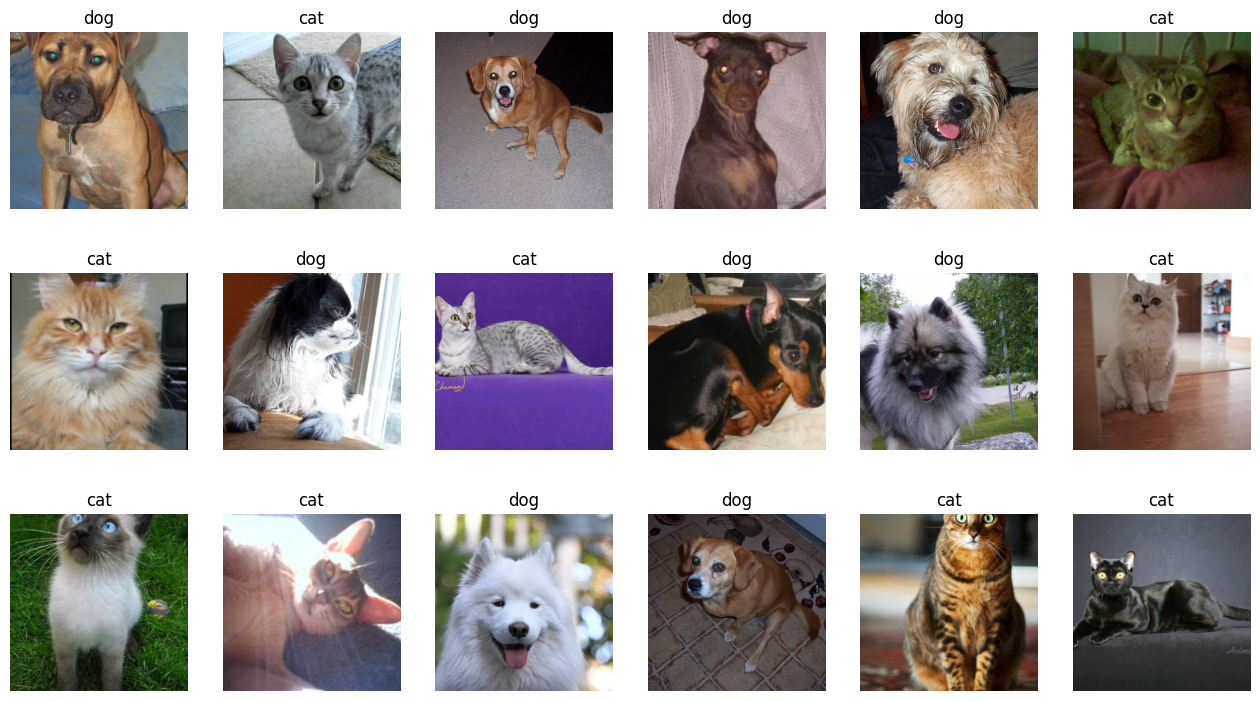

In [ ]:
# Check that images are cropped correctly
import matplotlib.pyplot as plt
import numpy as np

n_imgs = 18
n_cols = 6

data_handler = DataHandler(binary=True,
                           n_batch=100,
                           validation_proportion=0.2,
                           labeled_proportion=1.0)
train_loader, val_loader, test_loader = data_handler.get_loaders()

plt.figure(figsize=(16, 12))
for i in range(n_imgs):
  ax = plt.subplot(int(n_imgs/n_cols) + 1, n_cols, 1+i)
  idx = int((len(train_loader))*torch.rand(1))
  train_features, train_labels = next(iter(train_loader))
  img = train_features[idx].squeeze()
  label = train_labels[idx]
  plt.imshow(np.dstack(img))
  is_dog = label == 1
  ax.set_title('dog' if is_dog else 'cat')
  plt.axis('off')

# Theo

100%|██████████| 40/40 [36:26<00:00, 54.67s/it]


Final training accuracy:   100.0000%
Final validation accuracy: 99.7283%
Final testing accuracy:    99.2914%


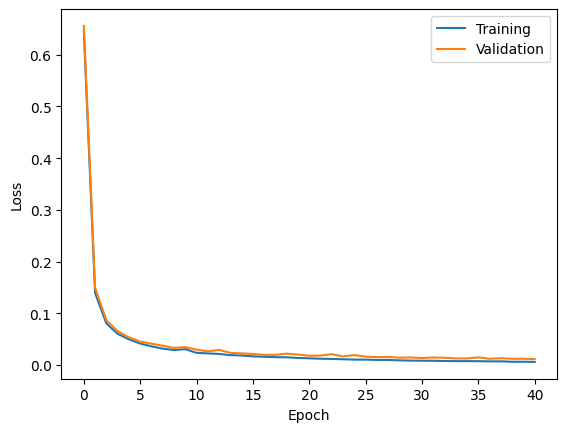

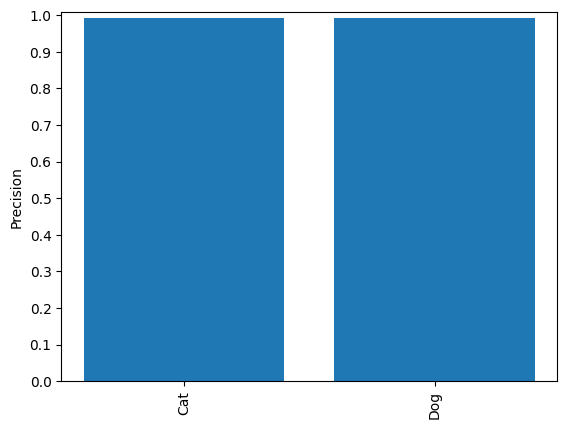

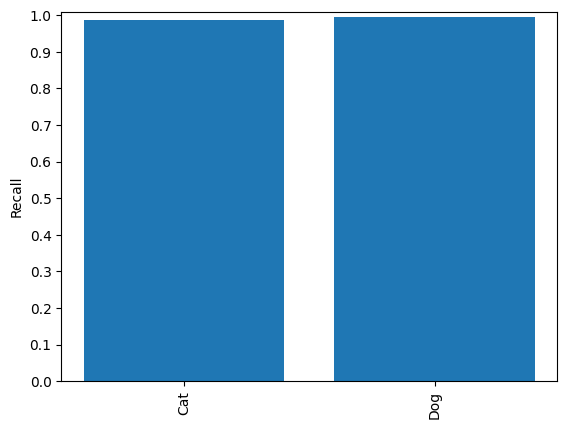

In [ ]:
### Baseline - Binary

trainer = NetworkManager(binary=True,
                         unfreeze_layers=False,
                         changing_lr=False,
                         augment_data=False,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=True, freeze=True, freeze_BN=True)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.001,
                                     track_loss=True)

trainer.report(model, train_loss, val_loss)

100%|██████████| 40/40 [36:35<00:00, 54.88s/it]


Final training accuracy:   99.2527%
Final validation accuracy: 92.6630%
Final testing accuracy:    89.6975%


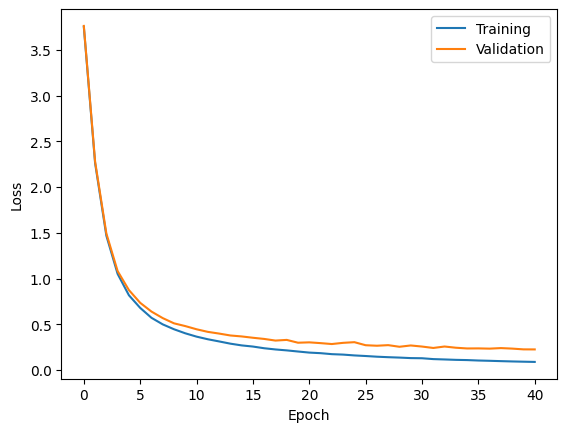

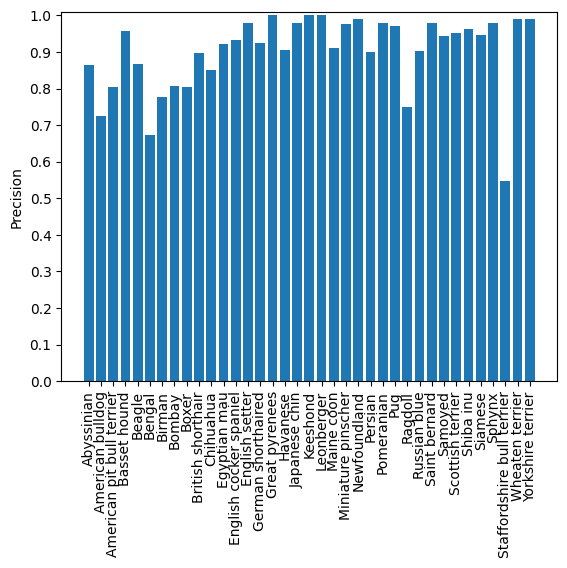

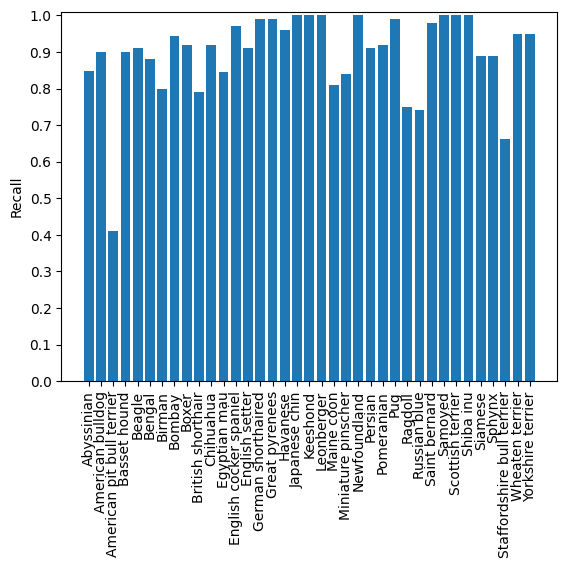

In [ ]:
### Baseline - Non-binary

trainer = NetworkManager(binary=False,
                         unfreeze_layers=False,
                         changing_lr=False,
                         augment_data=False,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=False, freeze=True, freeze_BN=True)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.001,
                                     track_loss=True)

trainer.report(model, train_loss, val_loss)

100%|██████████| 40/40 [36:58<00:00, 55.46s/it]


Final training accuracy:   99.7283%
Final validation accuracy: 99.5924%
Final testing accuracy:    99.2096%


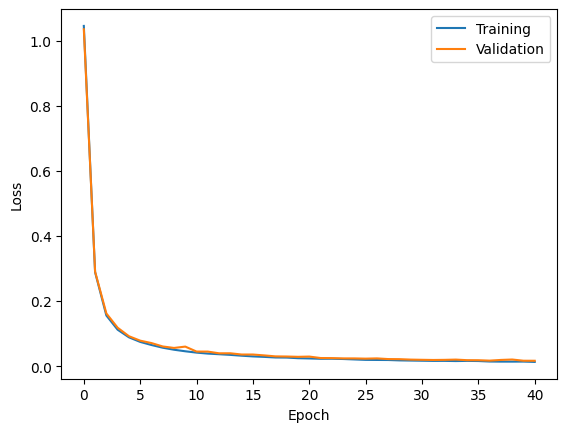

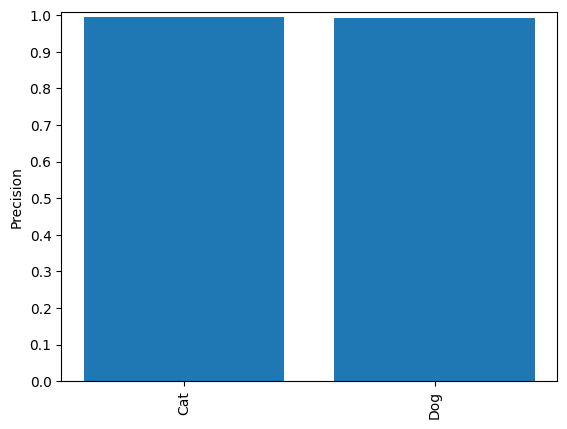

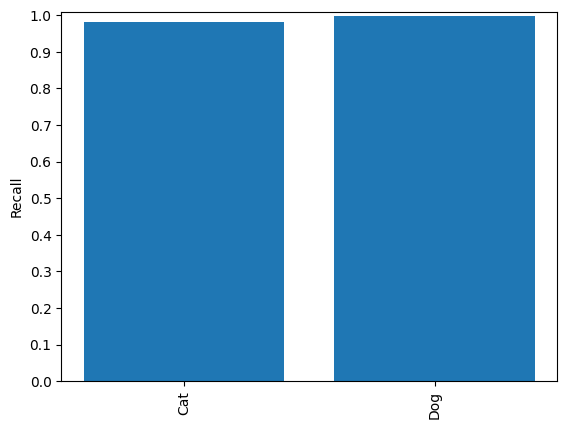

In [ ]:
### Augmented data - Binary

trainer = NetworkManager(binary=True,
                         unfreeze_layers=False,
                         changing_lr=False,
                         augment_data=True,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=True, freeze=True, freeze_BN=True)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.001,
                                     track_loss=True)

trainer.report(model, train_loss, val_loss)

100%|██████████| 40/40 [36:57<00:00, 55.45s/it]


Final training accuracy:   97.4525%
Final validation accuracy: 93.6141%
Final testing accuracy:    88.1439%


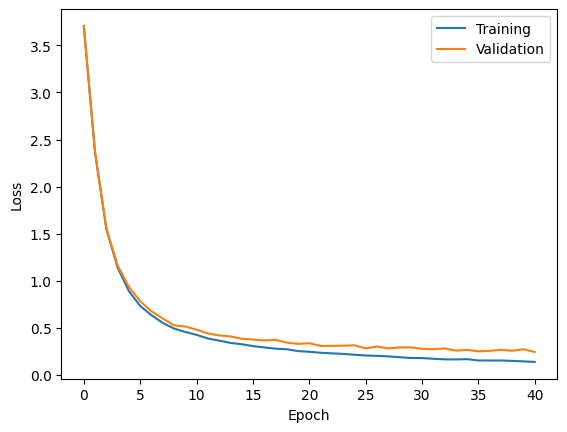

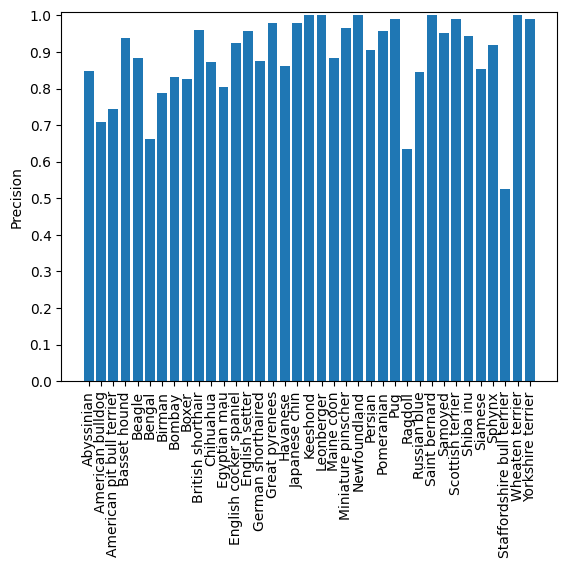

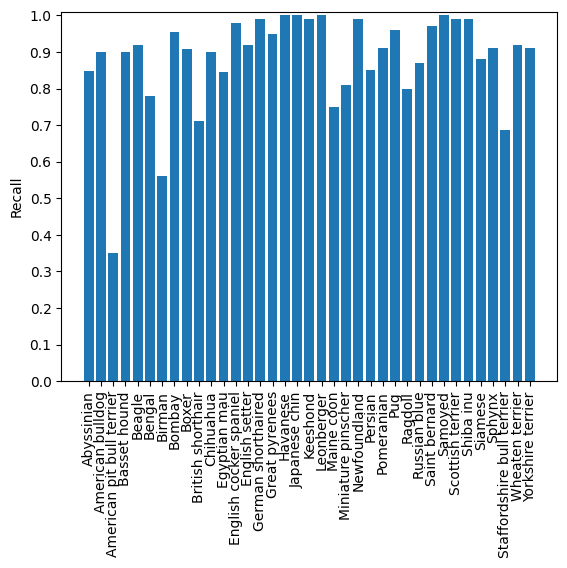

In [ ]:
### Augmented data - Non-binary

trainer = NetworkManager(binary=False,
                         unfreeze_layers=False,
                         changing_lr=False,
                         augment_data=True,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=False, freeze=True, freeze_BN=True)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.001,
                                     track_loss=True)

trainer.report(model, train_loss, val_loss)

In [4]:
### Augmented data - Non-binary more rot

trainer = NetworkManager(binary=False,
                         unfreeze_layers=False,
                         changing_lr=False,
                         augment_data=True,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=False, freeze=True, freeze_BN=True)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.001,
                                     track_loss=False)

trainer.report(model, train_loss, val_loss)

100%|██████████| 40/40 [14:16<00:00, 21.42s/it]


Final training accuracy:   97.3166%
Final validation accuracy: 92.3913%
Final testing accuracy:    87.8986%


ValueError: x, y, and format string must not be None

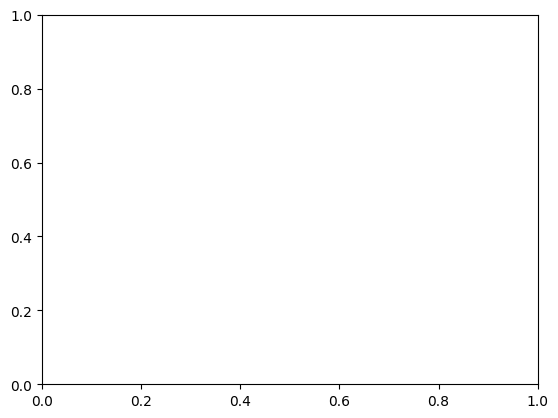

In [5]:
trainer.report(model, train_loss, val_loss)

100%|██████████| 40/40 [17:43<00:00, 26.58s/it]


Final training accuracy:   100.0000%
Final validation accuracy: 94.8370%
Final testing accuracy:    90.4879%


ValueError: x, y, and format string must not be None

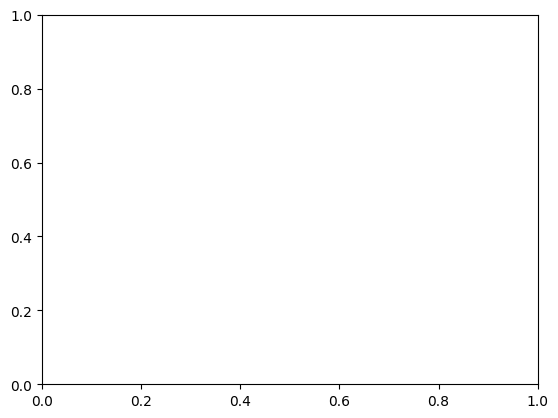

In [5]:
trainer = NetworkManager(binary=False,
                         unfreeze_layers=True,
                         changing_lr=False,
                         augment_data=False,
                         tune_batch_norm=True,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=False, freeze=True, freeze_BN=False, resnet50=False)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.0005,
                                     track_loss=False,
                                     unfreeze_every=5)

trainer.report(model, train_loss, val_loss)

# Magda

In [ ]:
### Multi class - Testing frequency of unfreezing

trainer = NetworkManager(binary=False,
                         unfreeze_layers=True,
                         changing_lr=False,
                         augment_data=True,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

val_accs = []
best_unfreeze = 4
for i in range(6):
  model = get_model(binary=False, freeze=True, freeze_BN=True) # Reinitialize model as to not have it already unfrozen to begin with
  print(f'Unfreezing every {i+1} epochs%')
  trainer.train(model, epochs=40, learning_rate=0.001, track_loss=False, unfreeze_every = i+1)

  accs = trainer.get_accuracies(model)
  print(f'Final training accuracy:   {accs["train"]*100:.4f}%')
  print(f'Final validation accuracy: {accs["val"]*100:.4f}%')
  print(f'Final testing accuracy:    {accs["test"]*100:.4f}%')
  val_accs.append(accs["val"])
best_val_acc = max(val_accs)
best_unfreeze = val_accs.index(best_val_acc)


#plt.plot(train_loss, label="Training")
#plt.plot(val_loss, label="Validation")
#plt.legend()
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.show()

Unfreezing every 1 epochs%


100%|██████████| 40/40 [15:19<00:00, 22.98s/it]


Final training accuracy:   99.1848%
Final validation accuracy: 90.7609%
Final testing accuracy:    86.6721%
Unfreezing every 2 epochs%


100%|██████████| 40/40 [15:03<00:00, 22.59s/it]


Final training accuracy:   99.2867%
Final validation accuracy: 91.0326%
Final testing accuracy:    86.4541%
Unfreezing every 3 epochs%


100%|██████████| 40/40 [14:44<00:00, 22.12s/it]


Final training accuracy:   99.3207%
Final validation accuracy: 89.8098%
Final testing accuracy:    88.4437%
Unfreezing every 4 epochs%


100%|██████████| 40/40 [14:31<00:00, 21.80s/it]


Final training accuracy:   98.0639%
Final validation accuracy: 88.8587%
Final testing accuracy:    87.1627%
Unfreezing every 5 epochs%


100%|██████████| 40/40 [14:26<00:00, 21.65s/it]


Final training accuracy:   99.8981%
Final validation accuracy: 92.1196%
Final testing accuracy:    89.7247%
Unfreezing every 6 epochs%


100%|██████████| 40/40 [14:14<00:00, 21.37s/it]


Final training accuracy:   99.5245%
Final validation accuracy: 91.8478%
Final testing accuracy:    86.5358%


In [ ]:
### Multi class - Testing frequency of unfreezing

trainer = NetworkManager(binary=False,
                         unfreeze_layers=True,
                         changing_lr=False,
                         augment_data=True,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

val_accs = []
best_unfreeze = 4
for i in range(6):
  model = get_model(binary=False, freeze=True, freeze_BN=True) # Reinitialize model as to not have it already unfrozen to begin with
  print(f'Unfreezing every {i+1} epochs%')
  trainer.train(model, epochs=40, learning_rate=0.001, track_loss=False, unfreeze_every = i+1)

  accs = trainer.get_accuracies(model)
  print(f'Final training accuracy:   {accs["train"]*100:.4f}%')
  print(f'Final validation accuracy: {accs["val"]*100:.4f}%')
  print(f'Final testing accuracy:    {accs["test"]*100:.4f}%')
  val_accs.append(accs["val"])
best_val_acc = max(val_accs)
best_unfreeze = val_accs.index(best_val_acc) + 1


#plt.plot(train_loss, label="Training")
#plt.plot(val_loss, label="Validation")
#plt.legend()
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.show()

Unfreezing every 1 epochs%


100%|██████████| 40/40 [15:16<00:00, 22.92s/it]


Final training accuracy:   99.1169%
Final validation accuracy: 90.2174%
Final testing accuracy:    86.9719%
Unfreezing every 2 epochs%


100%|██████████| 40/40 [15:02<00:00, 22.55s/it]


Final training accuracy:   99.2188%
Final validation accuracy: 90.2174%
Final testing accuracy:    85.5001%
Unfreezing every 3 epochs%


100%|██████████| 40/40 [14:45<00:00, 22.15s/it]


Final training accuracy:   97.5544%
Final validation accuracy: 87.5000%
Final testing accuracy:    85.3911%
Unfreezing every 4 epochs%


100%|██████████| 40/40 [14:29<00:00, 21.74s/it]


Final training accuracy:   99.3886%
Final validation accuracy: 90.2174%
Final testing accuracy:    87.4080%
Unfreezing every 5 epochs%


100%|██████████| 40/40 [14:23<00:00, 21.58s/it]


Final training accuracy:   99.1848%
Final validation accuracy: 89.2663%
Final testing accuracy:    85.3093%
Unfreezing every 6 epochs%


100%|██████████| 40/40 [14:19<00:00, 21.49s/it]


Final training accuracy:   98.8111%
Final validation accuracy: 89.8098%
Final testing accuracy:    88.0894%


In [ ]:
### Multi class - best unfreeze frequency and testing different lr
best_unfreeze = 5
trainer = NetworkManager(binary=False,
                         unfreeze_layers=True,
                         changing_lr=False,
                         augment_data=True,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

val_accs = []
LR = [0.005]
for i in range(len(LR)):
  model = get_model(binary=False, freeze=True, freeze_BN=True)
  print(f'LR =  {LR[i]}')
  trainer.train(model, epochs=40, learning_rate=LR[i], track_loss=False, unfreeze_every = best_unfreeze)

  accs = trainer.get_accuracies(model)
  print(f'Final training accuracy:   {accs["train"]*100:.4f}%')
  print(f'Final validation accuracy: {accs["val"]*100:.4f}%')
  print(f'Final testing accuracy:    {accs["test"]*100:.4f}%')
  val_accs.append(accs["val"])
best_val_acc = max(val_accs)
best_lr = val_accs.index(best_val_acc)

100%|██████████| 791918971/791918971 [00:09<00:00, 84676991.74it/s] 


Extracting data/trainval_breed/oxford-iiit-pet/images.tar.gz to data/trainval_breed/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 106205186.73it/s]


Extracting data/trainval_breed/oxford-iiit-pet/annotations.tar.gz to data/trainval_breed/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:05<00:00, 149033577.93it/s]


Extracting data/test_breed/oxford-iiit-pet/images.tar.gz to data/test_breed/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 66390637.47it/s]


Extracting data/test_breed/oxford-iiit-pet/annotations.tar.gz to data/test_breed/oxford-iiit-pet


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s]


LR =  0.005


100%|██████████| 40/40 [18:03<00:00, 27.08s/it]


Final training accuracy:   2.7174%
Final validation accuracy: 2.7174%
Final testing accuracy:    2.7255%


In [ ]:
### Multi class - best unfreeze frequency and lr, testing different gamma

trainer = NetworkManager(binary=False,
                         unfreeze_layers=True,
                         changing_lr=True,
                         augment_data=True,
                         tune_batch_norm=False,
                         pseudo_label=False,
                         labeled_proportion=1.0)

G = [1, 0.99, 0.95, 0.9, 0.8]
for i in range(len(G)):
  model = get_model(binary=False, freeze=True, freeze_BN=True)
  print(f'Gamma =  {G[i]}')
  trainer.train(model, epochs=40, learning_rate=best_lr, track_loss=False, unfreeze_every = best_unfreeze, gamma = G[i])

  accs = trainer.get_accuracies(model)
  print(f'Final training accuracy:   {accs["train"]*100:.4f}%')
  print(f'Final validation accuracy: {accs["val"]*100:.4f}%')
  print(f'Final testing accuracy:    {accs["test"]*100:.4f}%')

# Elliot

In [ ]:
# Update running mean and variance of batch norm layers during training (binary)
trainer = NetworkManager(binary=True,
                         unfreeze_layers=False,
                         changing_lr=False,
                         augment_data=False,
                         tune_batch_norm=True,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=True, freeze=True, freeze_BN=False)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.001,
                                     track_loss=True)

trainer.report(model, train_loss, val_loss, labeling_line=None)

 12%|█▎        | 5/40 [05:15<36:49, 63.12s/it]

In [ ]:
# Update running mean and variance of batch norm layers during training
trainer = NetworkManager(binary=False,
                         unfreeze_layers=False,
                         changing_lr=False,
                         augment_data=False,
                         tune_batch_norm=True,
                         pseudo_label=False,
                         labeled_proportion=1.0)

model = get_model(binary=False, freeze=True, freeze_BN=False)

train_loss, val_loss = trainer.train(model,
                                     epochs=40,
                                     learning_rate=0.001,
                                     track_loss=True)

trainer.report(model, train_loss, val_loss, labeling_line=None)

# B/A Level

In [ ]:
# Pseudo labeling
import copy
learn_rate = 0.0005
label_props = [0.01] #[0.5, 0.1, 0.01]
for is_binary in [False]: #[True, False]
  for lbl_prop in label_props:
    print(f'{"Binary" if is_binary else "Non-binary"} classification with {lbl_prop} labeling ratio:')
    trainer = NetworkManager(binary=is_binary,
                             unfreeze_layers=True,
                             changing_lr=False,
                             augment_data=True,
                             pseudo_label=True,
                             labeled_proportion=lbl_prop)

    m_0 = get_model(binary=is_binary, freeze=True, freeze_BN=True)
    trainer.train(m_0, epochs=40, learning_rate=0.00075, track_loss=False) #lr 0.0005

    accs = trainer.get_accuracies(m_0)
    print()
    print(f'Training accuracy after 40 epochs:   {accs["train"]*100:.2f}%')
    print(f'Validation accuracy after 40 epochs: {accs["val"]*100:.2f}%')
    print(f'Testing accuracy after 40 epochs:    {accs["test"]*100:.2f}%')

    m_1 = copy.deepcopy(m_0)
    m_pl = copy.deepcopy(m_0)
    trainer.train(m_1, epochs=20, learning_rate=0.00075, track_loss=False)  #lr 0.0005

    accs = trainer.get_accuracies(m_1)
    print()
    print(f'Training accuracy m_1:   {accs["train"]*100:.2f}%')
    print(f'Validation accuracy m_1: {accs["val"]*100:.2f}%')
    print(f'Testing accuracy m_1:    {accs["test"]*100:.2f}%')

    trainer.label_dataset(m_0, gradually=False)
    trainer.train(m_pl, epochs=20, learning_rate=0.00075, track_loss=False)  #lr 0.0005

    accs = trainer.get_accuracies(m_pl)
    print()
    print(f'Training accuracy m_pl:   {accs["train"]*100:.2f}%')
    print(f'Validation accuracy m_pl: {accs["val"]*100:.2f}%')
    print(f'Testing accuracy m_pl:    {accs["test"]*100:.2f}%')
    print('\n----------------------------------------------------------------\n')



Non-binary classification with 0.01 labeling ratio:
Had to change labeled proportion from 0.01 to 0.012907608695652174


100%|██████████| 40/40 [00:12<00:00,  3.33it/s]



Training accuracy after 40 epochs:   100.00%
Validation accuracy after 40 epochs: 26.36%
Testing accuracy after 40 epochs:    24.94%


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]



Training accuracy m_1:   100.00%
Validation accuracy m_1: 34.65%
Testing accuracy m_1:    31.15%


In [ ]:
# Pseudo labeling
import copy
learn_rate = 0.0005
lrs = [0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001] #[0.5, 0.1, 0.01]
for l in lrs:
  print(f'Non-binary classification with learning rate {l}')
  trainer = NetworkManager(binary=is_binary,
                            unfreeze_layers=True,
                            changing_lr=False,
                            augment_data=True,
                            pseudo_label=True,
                            labeled_proportion=lbl_prop)

  m_0 = get_model(binary=is_binary, freeze=True, freeze_BN=True)
  trainer.train(m_0, epochs=40, learning_rate=l, track_loss=False) #lr 0.0005

  accs = trainer.get_accuracies(m_0)
  print()
  print(f'Training accuracy after 40 epochs:   {accs["train"]*100:.2f}%')
  print(f'Validation accuracy after 40 epochs: {accs["val"]*100:.2f}%')
  print(f'Testing accuracy after 40 epochs:    {accs["test"]*100:.2f}%')

  m_1 = copy.deepcopy(m_0)
  m_pl = copy.deepcopy(m_0)
  trainer.train(m_1, epochs=20, learning_rate=l, track_loss=False)  #lr 0.0005

  accs = trainer.get_accuracies(m_1)
  print()
  print(f'Training accuracy m_1:   {accs["train"]*100:.2f}%')
  print(f'Validation accuracy m_1: {accs["val"]*100:.2f}%')
  print(f'Testing accuracy m_1:    {accs["test"]*100:.2f}%')

  trainer.label_dataset(m_0, gradually=False)
  trainer.train(m_pl, epochs=20, learning_rate=l, track_loss=False)  #lr 0.0005

  accs = trainer.get_accuracies(m_pl)
  print()
  print(f'Training accuracy m_pl:   {accs["train"]*100:.2f}%')
  print(f'Validation accuracy m_pl: {accs["val"]*100:.2f}%')
  print(f'Testing accuracy m_pl:    {accs["test"]*100:.2f}%')
  print('\n----------------------------------------------------------------\n')


Non-binary classification with learning rate 0.0005
Had to change labeled proportion from 0.01 to 0.012907608695652174


100%|██████████| 40/40 [00:11<00:00,  3.41it/s]



Training accuracy after 40 epochs:   100.00%
Validation accuracy after 40 epochs: 26.49%
Testing accuracy after 40 epochs:    24.75%


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]



Training accuracy m_1:   100.00%
Validation accuracy m_1: 35.73%
Testing accuracy m_1:    32.38%


100%|██████████| 20/20 [07:50<00:00, 23.51s/it]



Training accuracy m_pl:   89.20%
Validation accuracy m_pl: 23.23%
Testing accuracy m_pl:    21.80%

----------------------------------------------------------------

Non-binary classification with learning rate 0.0006
Had to change labeled proportion from 0.01 to 0.012907608695652174


100%|██████████| 40/40 [00:11<00:00,  3.42it/s]



Training accuracy after 40 epochs:   100.00%
Validation accuracy after 40 epochs: 37.77%
Testing accuracy after 40 epochs:    34.61%


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]



Training accuracy m_1:   100.00%
Validation accuracy m_1: 27.72%
Testing accuracy m_1:    24.28%


100%|██████████| 20/20 [07:51<00:00, 23.56s/it]



Training accuracy m_pl:   98.98%
Validation accuracy m_pl: 39.27%
Testing accuracy m_pl:    34.56%

----------------------------------------------------------------

Non-binary classification with learning rate 0.0007
Had to change labeled proportion from 0.01 to 0.012907608695652174


100%|██████████| 40/40 [00:11<00:00,  3.44it/s]



Training accuracy after 40 epochs:   100.00%
Validation accuracy after 40 epochs: 24.18%
Testing accuracy after 40 epochs:    22.84%


100%|██████████| 20/20 [00:06<00:00,  3.25it/s]



Training accuracy m_1:   100.00%
Validation accuracy m_1: 30.57%
Testing accuracy m_1:    28.67%


100%|██████████| 20/20 [07:49<00:00, 23.46s/it]



Training accuracy m_pl:   94.63%
Validation accuracy m_pl: 17.93%
Testing accuracy m_pl:    18.12%

----------------------------------------------------------------

Non-binary classification with learning rate 0.0008
Had to change labeled proportion from 0.01 to 0.012907608695652174


100%|██████████| 40/40 [00:11<00:00,  3.44it/s]



Training accuracy after 40 epochs:   100.00%
Validation accuracy after 40 epochs: 34.10%
Testing accuracy after 40 epochs:    32.11%


100%|██████████| 20/20 [00:06<00:00,  3.26it/s]



Training accuracy m_1:   100.00%
Validation accuracy m_1: 31.39%
Testing accuracy m_1:    30.31%


100%|██████████| 20/20 [07:49<00:00, 23.46s/it]



Training accuracy m_pl:   96.94%
Validation accuracy m_pl: 32.20%
Testing accuracy m_pl:    30.42%

----------------------------------------------------------------

Non-binary classification with learning rate 0.0009
Had to change labeled proportion from 0.01 to 0.012907608695652174


100%|██████████| 40/40 [00:11<00:00,  3.55it/s]



Training accuracy after 40 epochs:   100.00%
Validation accuracy after 40 epochs: 33.42%
Testing accuracy after 40 epochs:    30.23%


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]



Training accuracy m_1:   100.00%
Validation accuracy m_1: 26.09%
Testing accuracy m_1:    23.88%


100%|██████████| 20/20 [07:48<00:00, 23.45s/it]



Training accuracy m_pl:   94.50%
Validation accuracy m_pl: 32.07%
Testing accuracy m_pl:    29.74%

----------------------------------------------------------------

Non-binary classification with learning rate 0.001
Had to change labeled proportion from 0.01 to 0.012907608695652174


100%|██████████| 40/40 [00:11<00:00,  3.60it/s]



Training accuracy after 40 epochs:   100.00%
Validation accuracy after 40 epochs: 29.35%
Testing accuracy after 40 epochs:    28.35%


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]



Training accuracy m_1:   97.37%
Validation accuracy m_1: 25.82%
Testing accuracy m_1:    23.28%


100%|██████████| 20/20 [07:48<00:00, 23.41s/it]



Training accuracy m_pl:   96.67%
Validation accuracy m_pl: 25.54%
Testing accuracy m_pl:    24.99%

----------------------------------------------------------------



In [16]:
# Pseudo labeling
import copy
l = 0.0006
print(f'Non-binary classification with learning rate {l}')
trainer = NetworkManager(binary=is_binary,
                          unfreeze_layers=True,
                          changing_lr=False,
                          augment_data=True,
                          pseudo_label=True,
                          labeled_proportion=lbl_prop)

m_0 = get_model(binary=True, freeze=True, freeze_BN=True)
trainer.train(m_0, epochs=40, learning_rate=l, track_loss=False) #lr 0.0005

accs = trainer.get_accuracies(m_0)
print()
print(f'Training accuracy after 40 epochs:   {accs["train"]*100:.2f}%')
print(f'Validation accuracy after 40 epochs: {accs["val"]*100:.2f}%')
print(f'Testing accuracy after 40 epochs:    {accs["test"]*100:.2f}%')

m_1 = copy.deepcopy(m_0)
m_pl = copy.deepcopy(m_0)
trainer.train(m_1, epochs=20, learning_rate=l, track_loss=False)  #lr 0.0005

accs = trainer.get_accuracies(m_1)
print()
print(f'Training accuracy m_1:   {accs["train"]*100:.2f}%')
print(f'Validation accuracy m_1: {accs["val"]*100:.2f}%')
print(f'Testing accuracy m_1:    {accs["test"]*100:.2f}%')

trainer.label_dataset(m_0, gradually=False)
trainer.train(m_pl, epochs=20, learning_rate=l, track_loss=False)  #lr 0.0005

accs = trainer.get_accuracies(m_pl)
print()
print(f'Training accuracy m_pl:   {accs["train"]*100:.2f}%')
print(f'Validation accuracy m_pl: {accs["val"]*100:.2f}%')
print(f'Testing accuracy m_pl:    {accs["test"]*100:.2f}%')
print('\n----------------------------------------------------------------\n')


Non-binary classification with learning rate 0.0006
Had to change labeled proportion from 0.01 to 0.012907608695652174


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
